In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
# import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1."
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"

In [3]:
import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from momi3.Params import Params
from momi3.MOMI import Momi

import re
import math
import pickle

from tqdm.notebook import tqdm

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp


/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# Load demes graph
demo = demes.load("arc5.yaml")
sampled_demes = demo.metadata['sampled_demes']
sample_sizes = demo.metadata['sample_sizes']

In [5]:
jsfs = np.load('jsfs_UNIF_Papuan_Sardinian_YRI_Vindija_Denisovan_50_108.npy')

In [6]:
jsfs.shape

(31, 51, 51, 3, 3)

In [7]:
(jsfs != 0.).sum()

208967

In [8]:
# Construct momi
momi = Momi(demo, sampled_demes=sampled_demes, sample_sizes=sample_sizes, batch_size=70000, low_memory=True)
params = Params(momi)
bounds = momi.bound_sampler(params, 1000, seed=108)
momi = momi.bound(bounds)

In [9]:
params.set_train_all_etas(True)
params.set_train('eta_0', False)
params.set_train_all_pis(True)

In [10]:
with open(f'bootstrap_outs_large/arc5_bs_0.pickle', 'rb') as f:
    ret = pickle.load(f)
theta_hat = ret['ttd']
params.set_optimization_results(theta_hat)

In [11]:
momi.loglik(params, jsfs)

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/math_functions.py:14: UserWarning: Explicitly requested dtype float requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x = jnp.array(x, dtype='float')


-40209780.0

In [12]:
# read bs outs
df = []
succ = []
import pickle
for i in range(1, 250):
    try:
        with open(f'bootstrap_outs_large/arc5_bs_{i}.pickle', 'rb') as f:
            ret = pickle.load(f)
        if ret['optret'].success:
            df.append(ret['ttd'])
        
    except:
        pass

df = pd.DataFrame(df)

In [13]:
sd = df.std().to_dict() # sd of estimates


a = 0.05
dx = df.quantile([a/2, 1-a/2]) # quantiles

dx[['eta_1', 'eta_2', 'eta_3', 'eta_4', 'eta_5', 'eta_6', 'eta_7']] = dx[['eta_1', 'eta_2', 'eta_3', 'eta_4', 'eta_5', 'eta_6', 'eta_7']].astype('int')
dx[['pi_0', 'pi_1']] = dx[['pi_0', 'pi_1']].round(3)

In [14]:
split_line = '\\\\\n'

dx = dx.style.to_latex().split(split_line)[1:]
dx = split_line.join(dx)

head = '\\begin{tabular}{l|rrrrrrrrr}\n\\bfseries n & \\bfseries TV \\\ \n'
head += '\hline\hline \n'
dx = head + dx

In [15]:
print(dx)

\begin{tabular}{l|rrrrrrrrr}
\bfseries n & \bfseries TV \\ 
\hline\hline 
0.025000 & 23148 & 2022 & 16359 & 1007 & 6295 & 4581 & 2378 & 0.025000 & 0.017000 \\
0.975000 & 24278 & 2217 & 18847 & 1155 & 8094 & 4817 & 2514 & 0.026000 & 0.022000 \\
\end{tabular}



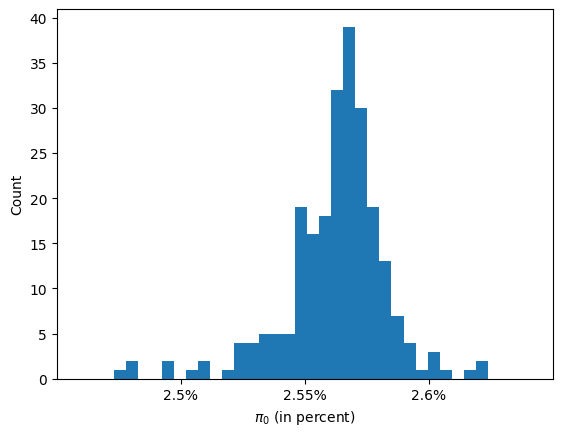

In [16]:
xlines = [2.50, 2.55, 2.6]
plt.hist(df['pi_0'] * 100, bins=50)
plt.ylabel('Count')
plt.xlabel('$\pi_0$ (in percent)')
plt.xticks(xlines, [f'{i}%' for i in xlines])
plt.xlim(2.45, 2.65)
plt.savefig(f"Den_Pap.pdf", format="pdf", bbox_inches="tight", dpi=600)

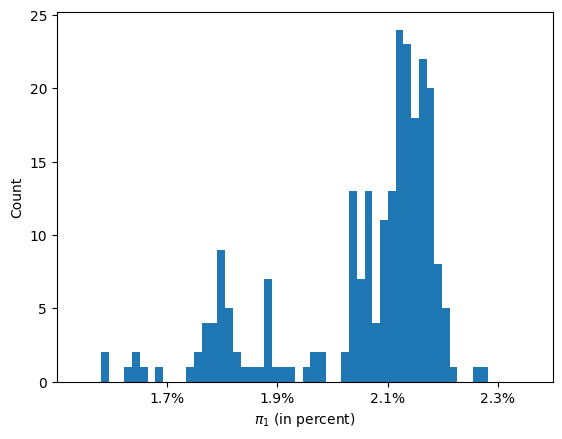

In [17]:
xlines = [1.7, 1.9, 2.1, 2.3]
plt.hist(df['pi_1'] * 100, bins=50)
plt.ylabel('Count')
plt.xlabel('$\pi_1$ (in percent)')
plt.xticks(xlines, [f'{i}%' for i in xlines])
plt.xlim(1.5, 2.4)
plt.savefig(f"Vin_NonAfr.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [18]:
SNR = {i: theta_hat[i] / sd[i] for i in sd} # Signal to noise ratio

In [19]:
SNR

{'eta_1': 78.54824663282412,
 'eta_2': 36.57339386678489,
 'eta_3': 25.92599581233748,
 'eta_4': 23.369258950711874,
 'eta_5': 14.1708717674147,
 'eta_6': 85.31979741704276,
 'eta_7': 66.54588302922399,
 'pi_0': 106.81684573551864,
 'pi_1': 14.126575096051774}

In [20]:
from momi3.utils import halfsigmoid
f = lambda x: halfsigmoid(1/x, 0.03)

In [21]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

In [22]:
vals = list(SNR.values())
colors = [(1.0, 1.0, 1.0), (1.0, 0, 0)]
cm = mcolors.LinearSegmentedColormap.from_list("Custom", colors)
box_color = cm(f(np.linspace(min(vals), max(vals), 100)))
my_cmap = ListedColormap(box_color)

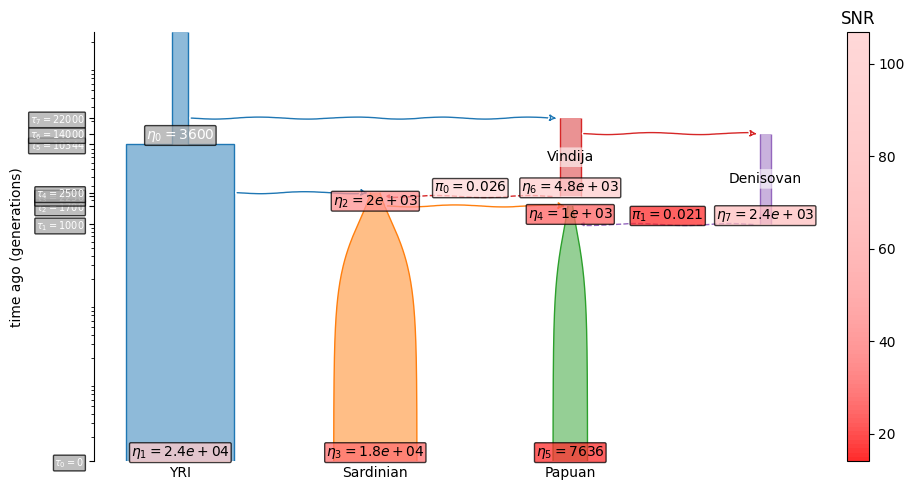

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
params.tubes(True, True, log_time = True, USER_DICT=SNR,color_intensity_function=f, tau_font_size=7, ax=ax)
c = plt.pcolor(np.zeros((1, 1)),linewidths=0, cmap=my_cmap, vmin=min(vals), vmax=max(vals))
clb = plt.colorbar(c)
clb.ax.set_title('SNR')
plt.tight_layout()

plt.savefig(f"5arc_demo_plot_with_SNR.pdf", format="pdf", bbox_inches="tight", dpi=600)